In [1]:
import yt
import numpy as np
import matplotlib.pyplot as plt
# from glob import glob

# ===============================

def VortexError(datasets, v0, beta, R, xc, yc):
  errors = np.zeros((6, len(datasets))) # L1, L2, Linf errors

  for d in range(len(datasets)):
    ad = yt.load(datasets[d]).all_data()
    x = np.array(ad["x"])
    y = np.array(ad["y"])
    u = np.array(ad["velocity_x"])
    v = np.array(ad["velocity_y"])
    
    r = np.sqrt((x-xc)**2 + (y-yc)**2)
    u_exact = v0*(1-beta*(y-yc)/R*np.exp(-0.5*(r/R)**2))
    v_exact = v0*beta*(x-xc)/R*np.exp(-0.5*(r/R)**2)

    errors[0,d] = np.mean(np.abs(u - u_exact))
    errors[1,d] = np.sqrt(np.mean((u - u_exact)**2))
    errors[2,d] = np.max(np.abs(u - u_exact))
    errors[3,d] = np.mean(np.abs(v - v_exact))
    errors[4,d] = np.sqrt(np.mean((v - v_exact)**2))
    errors[5,d] = np.max(np.abs(v - v_exact))

  return errors

def VortexLineout(datasets, xc, yc):
  x_out = []
  v_out = []
  y_out = []
  u_out = []

  for d in range(len(datasets)):
    ds = yt.load(datasets[d])

    xaxis = 0  # take a line cut along x axis
    lineout = ds.ortho_ray(xaxis, (yc, 0))
    srt = np.argsort(lineout["x"])
    x = np.array(lineout["x"][srt])
    v = np.array(lineout["velocity_y"][srt])
    x_out.append(x)
    v_out.append(v)

    xaxis = 1  # take a line cut along y axis
    lineout = ds.ortho_ray(xaxis, (0, xc))
    srt = np.argsort(lineout["y"])
    y = np.array(lineout["y"][srt])
    u = np.array(lineout["velocity_x"][srt])
    y_out.append(y)
    u_out.append(u)

  return x_out, v_out, y_out, u_out

### Slow vortex

In [24]:
v0 = 0.05 * np.sqrt(1.4 * 287 * 300) * 100 # convection velocity 1735.95
beta = 0.02  # vortex strength
R = 0.5
xc = (5.0 + ((0.288 * v0) % 10.0)) % 10.0
yc = 5.0

# WENO-Z w/o AMR
datasets = ["slow/grid32/plt336010", "slow/grid64/plt672161", 
            "slow/grid128/plt1344596", "slow/grid256/plt2689299"]
# WENO-Z w/ AMR
# datawamr = ["test1/amr32/plt112159", "test1/amr64/plt112027/", 
#             "test1/amr128/plt112050/", "test1/amr256/plt112055/"]
dx = 10.0 / np.array([32, 64, 128, 256], dtype=np.float)
errors = VortexError(datasets, v0, beta, R, xc, yc)
# erramr = VortexError(datawamr, v0, beta, R, xc, yc)

x, v, y, u = VortexLineout(datasets, xc, yc)

/tmp/ipykernel_1427538/1392349999.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dx = 10.0 / np.array([32, 64, 128, 256], dtype=np.float)
yt : [INFO     ] 2023-04-11 12:25:51,415 Parameters: current_time              = 0.288
yt : [INFO     ] 2023-04-11 12:25:51,416 Parameters: domain_dimensions         = [32 32  1]
yt : [INFO     ] 2023-04-11 12:25:51,417 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-04-11 12:25:51,418 Parameters: domain_right_edge         = [10. 10.  1.]
yt : [INFO     ] 2023-04-11 12:25:51,731 Parameters: current_time              = 0.288
yt : [INFO     ] 2023-04-11 12:25:51,732 Parameters: domain_dimensions   

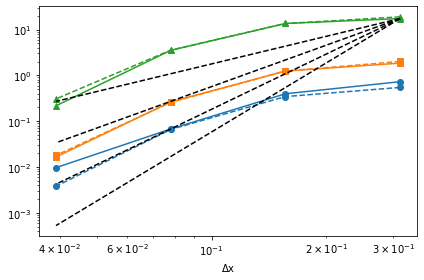

In [25]:
plt.loglog(dx, errors[0,:], 'o-', color='C0')
plt.loglog(dx, errors[1,:], 's-', color='C1')
plt.loglog(dx, errors[2,:], '^-', color='C2')
plt.loglog(dx, errors[3,:], 'o--', color='C0')
plt.loglog(dx, errors[4,:], 's--', color='C1')
plt.loglog(dx, errors[5,:], '^--', color='C2')
# plt.loglog(dx, erramr[0,:], 'x-.', color='C0')
# plt.loglog(dx, erramr[1,:], 'x-.', color='C1')
# plt.loglog(dx, erramr[2,:], 'x-.', color='C2')
plt.loglog(dx, errors[2,0]/dx[0]**2 * dx**2, "k--")
plt.loglog(dx, errors[2,0]/dx[0]**3 * dx**3, "k--")
plt.loglog(dx, errors[2,0]/dx[0]**4 * dx**4, "k--")
plt.loglog(dx, errors[2,0]/dx[0]**5 * dx**5, "k--")

plt.xlabel(r"$\Delta$x")
# plt.legend([r"Coarse kinetic energy", r"Multi-lev kinetic energy", r"Coarse enstrophy", r"Multi-lev enstrophy", "Analytical"], loc="upper right")
plt.tight_layout()

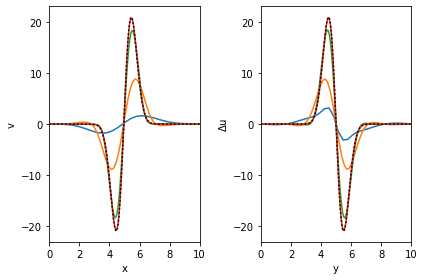

In [4]:
xp = np.linspace(0, 10, 300)
u_exact = -v0*beta*(xp-yc)/R*np.exp(-0.5*((xp-yc)/R)**2)
v_exact = v0*beta*(xp-xc)/R*np.exp(-0.5*((xp-xc)/R)**2)

plt.subplot(1,2,1)
for (xs, vs) in zip(x, v):
  plt.plot(xs, vs)
plt.plot(xp, v_exact, 'k:')
plt.xlim([0,10])
plt.xlabel("x")
plt.ylabel("v")

plt.subplot(1,2,2)
for (ys, us) in zip(y, u):
  plt.plot(ys, us-us[0])
plt.plot(xp, u_exact, 'k:')
plt.xlim([0,10])
plt.xlabel("y")
plt.ylabel(r"$\Delta$u")

plt.tight_layout()

### Fast vortex

In [31]:
v0 = 0.5 * np.sqrt(1.4 * 287 * 300) * 100 # convection velocity
beta = 0.2  # vortex strength
R = 0.5
xc = (5.0 + ((0.0288 * v0) % 10.0)) % 10.0
yc = 5.0

# WENO-Z
datasets = ["fast/grid32/plt48253", "fast/grid64/plt97972", "fast/grid128/plt199488", "fast/grid256/plt399243"]
# TENO
datateno = ["fast2/grid32/plt48511", "fast2/grid64/plt98152", "fast2/grid128/plt199473", "fast2/grid256/plt399242"]

dx = 10.0 / np.array([32, 64, 128, 256], dtype=np.float)
errors = VortexError(datasets, v0, beta, R, xc, yc)
erteno = VortexError(datateno, v0, beta, R, xc, yc)

x, v, y, u = VortexLineout(datasets, xc, yc)

/tmp/ipykernel_1427538/1210198480.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dx = 10.0 / np.array([32, 64, 128, 256], dtype=np.float)
yt : [INFO     ] 2023-04-11 20:28:44,272 Parameters: current_time              = 0.0288
yt : [INFO     ] 2023-04-11 20:28:44,273 Parameters: domain_dimensions         = [32 32  1]
yt : [INFO     ] 2023-04-11 20:28:44,274 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-04-11 20:28:44,276 Parameters: domain_right_edge         = [10. 10.  1.]
yt : [INFO     ] 2023-04-11 20:28:44,602 Parameters: current_time              = 0.0288
yt : [INFO     ] 2023-04-11 20:28:44,603 Parameters: domain_dimensions 

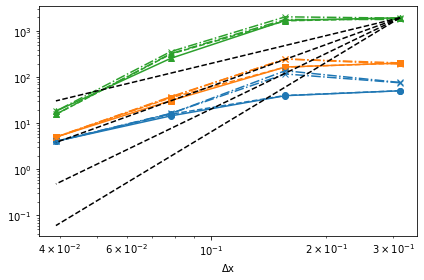

In [32]:
plt.loglog(dx, errors[0,:], 'o-', color='C0')
plt.loglog(dx, errors[1,:], 's-', color='C1')
plt.loglog(dx, errors[2,:], '^-', color='C2')
plt.loglog(dx, errors[3,:], 'o--', color='C0')
plt.loglog(dx, errors[4,:], 's--', color='C1')
plt.loglog(dx, errors[5,:], '^--', color='C2')
plt.loglog(dx, erteno[0,:], 'x-.', color='C0')
plt.loglog(dx, erteno[1,:], 'x-.', color='C1')
plt.loglog(dx, erteno[2,:], 'x-.', color='C2')
plt.loglog(dx, erteno[3,:], 'x-.', color='C0')
plt.loglog(dx, erteno[4,:], 'x-.', color='C1')
plt.loglog(dx, erteno[5,:], 'x-.', color='C2')
plt.loglog(dx, errors[2,0]/dx[0]**2 * dx**2, "k--")
plt.loglog(dx, errors[2,0]/dx[0]**3 * dx**3, "k--")
plt.loglog(dx, errors[2,0]/dx[0]**4 * dx**4, "k--")
plt.loglog(dx, errors[2,0]/dx[0]**5 * dx**5, "k--")

plt.xlabel(r"$\Delta$x")
# plt.legend([r"Coarse kinetic energy", r"Multi-lev kinetic energy", r"Coarse enstrophy", r"Multi-lev enstrophy", "Analytical"], loc="upper right")
plt.tight_layout()

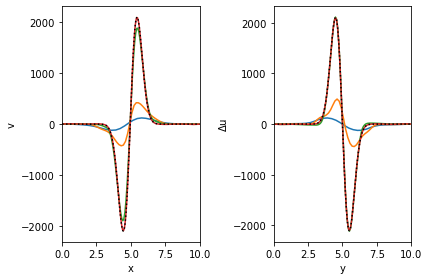

In [9]:
xp = np.linspace(0, 10, 300)
u_exact = -v0*beta*(xp-yc)/R*np.exp(-0.5*((xp-yc)/R)**2)
v_exact = v0*beta*(xp-xc)/R*np.exp(-0.5*((xp-xc)/R)**2)

plt.subplot(1,2,1)
for (xs, vs) in zip(x, v):
  plt.plot(xs, vs)
plt.plot(xp, v_exact, 'k:')
plt.xlim([0,10])
plt.xlabel("x")
plt.ylabel("v")

plt.subplot(1,2,2)
for (ys, us) in zip(y, u):
  plt.plot(ys, us-us[0])
plt.plot(xp, u_exact, 'k:')
plt.xlim([0,10])
plt.xlabel("y")
plt.ylabel(r"$\Delta$u")

plt.tight_layout()